# Stock Market Prediction using Numerical and Textual Analysis

● Objective: Create a hybrid model for stock price/performance prediction using numerical analysis of historical stock prices, and sentimental analysis of news headlines

● Stock to analyze and predict - SENSEX (S&P BSE SENSEX)

● Download historical stock prices from finance.yahoo.com

**I have used Auto-ARIMA model to make stock market prices predictions using the historical stock prices data. In the sentiment analysis model, I have made use of different machine learning algorithms-Random Forest Regressor, LightGBM, Adaboost and Xgboost- to make the predictions.**

In [2]:
from google.colab import files 
uploaded = files.upload()

Saving BSESN.csv to BSESN.csv


In [1]:
from google.colab import files 
uploaded = files.upload()

Saving india-news-headlines.csv to india-news-headlines.csv


In [43]:
import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('vader_lexicon')
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
import xgboost 
import lightgbm 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [17]:
!pip install pmdarima

     |████████████████████████████████| 1.5MB 2.4MB/s 
     |████████████████████████████████| 8.7MB 6.9MB/s 
     |████████████████████████████████| 808kB 47.9MB/s 
     |████████████████████████████████| 2.1MB 40.2MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
  Found existing installation: setuptools 50.3.0
    Uninstalling setuptools-50.3.0:
      Successfully uninstalled setuptools-50.3.0
  Found existing installation: Cython 0.29.21
    Uninstalling Cython-0.29.21:
      Successfully uninstalled Cython-0.29.21


TIME SERIES ANALYSIS

In [2]:
df_prices = pd.read_csv('BSESN.csv')
print(df_prices.head())
print(df_prices.size)

         Date          Open          High  ...         Close     Adj Close   Volume
0  2015-01-02  27521.279297  27937.470703  ...  27887.900391  27887.900391   7400.0
1  2015-01-05  27978.429688  28064.490234  ...  27842.320313  27842.320313   9200.0
2  2015-01-06  27694.230469  27698.929688  ...  26987.460938  26987.460938  14100.0
3  2015-01-07  26983.429688  27051.599609  ...  26908.820313  26908.820313  12200.0
4  2015-01-08  27178.769531  27316.410156  ...  27274.710938  27274.710938   8200.0

[5 rows x 7 columns]
8596


In [3]:
#Converting Date column to datetime datatype
df_prices['Date'] = pd.to_datetime(df_prices['Date'])
df_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1228 entries, 0 to 1227
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1228 non-null   datetime64[ns]
 1   Open       1224 non-null   float64       
 2   High       1224 non-null   float64       
 3   Low        1224 non-null   float64       
 4   Close      1224 non-null   float64       
 5   Adj Close  1224 non-null   float64       
 6   Volume     1224 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 67.3 KB


In [4]:
df_prices.dropna(inplace = True)

Text(0, 0.5, 'Close')

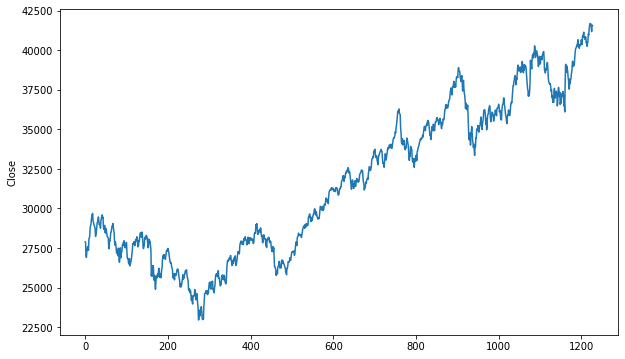

In [5]:
plt.figure(figsize=(10, 6))
df_prices['Close'].plot()
plt.ylabel('Close')

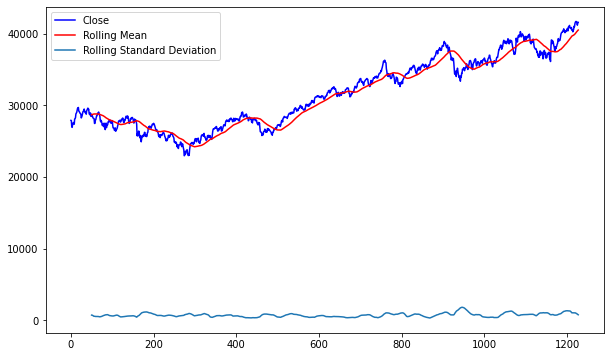

In [6]:
#Plotting moving average
close = df_prices['Close']
ma = close.rolling(window = 50).mean()
std = close.rolling(window = 50).std()

plt.figure(figsize=(10, 6))
df_prices['Close'].plot(color = 'b', label = 'Close')
ma.plot(color = 'r', label = 'Rolling Mean')
std.plot(label = 'Rolling Standard Deviation')
plt.legend()

Text(0.5, 1.0, 'Returns')

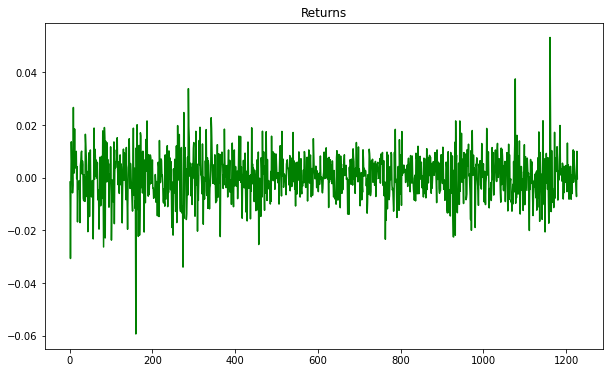

In [7]:
#Plotting returns
returns = close / close.shift(1) - 1

plt.figure(figsize = (10,6))
returns.plot(label='Return', color = 'g')
plt.title("Returns")

In [73]:
train = df_prices[:1000]
test = df_prices[1000:]

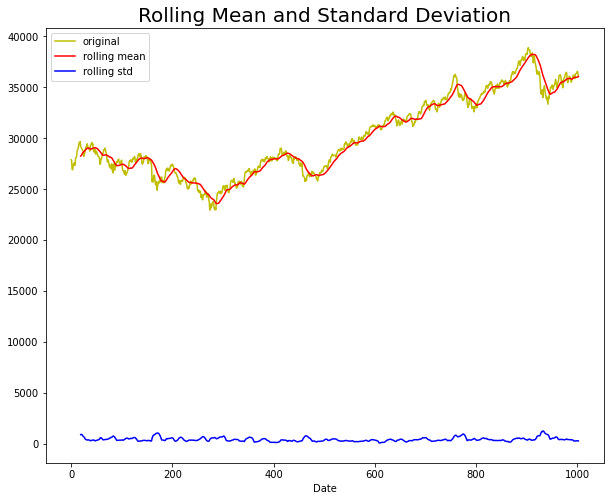

Results of dickey fuller test
ADF Test Statistic : -0.5913676380957044
p-value : 0.8729206808204099
#Lags Used : 1
Number of Observations Used : 998
Weak evidence against null hypothesis, time series is non-stationary 


In [74]:
#Stationarity test
def test_stationarity(timeseries):

 #Determing rolling statistics
 rolmean = timeseries.rolling(20).mean()
 rolstd = timeseries.rolling(20).std()

 #Plot rolling statistics:
 plt.figure(figsize = (10,8))
 plt.plot(timeseries, color = 'y', label = 'original')
 plt.plot(rolmean, color = 'r', label = 'rolling mean')
 plt.plot(rolstd, color = 'b', label = 'rolling std')
 plt.xlabel('Date')
 plt.legend()
 plt.title('Rolling Mean and Standard Deviation',  fontsize = 20)
 plt.show(block = False)
 
 print('Results of dickey fuller test')
 result = adfuller(timeseries, autolag = 'AIC')
 labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
 for value,label in zip(result, labels):
   print(label+' : '+str(value) )
 if result[1] <= 0.05:
   print("Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
 else:
   print("Weak evidence against null hypothesis, time series is non-stationary ")
test_stationarity(train['Close'])

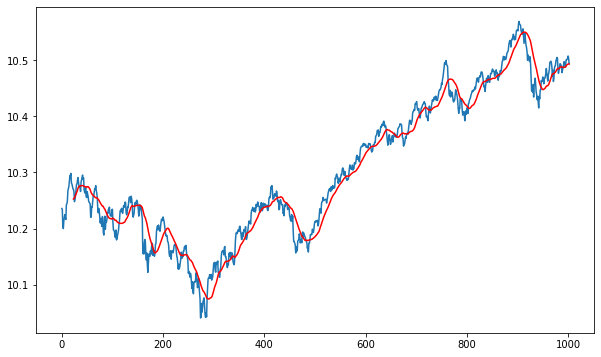

In [75]:
train_log = np.log(train['Close']) 
test_log = np.log(test['Close'])

mav = train_log.rolling(24).mean() 
plt.figure(figsize = (10,6))
plt.plot(train_log) 
plt.plot(mav, color = 'red') 

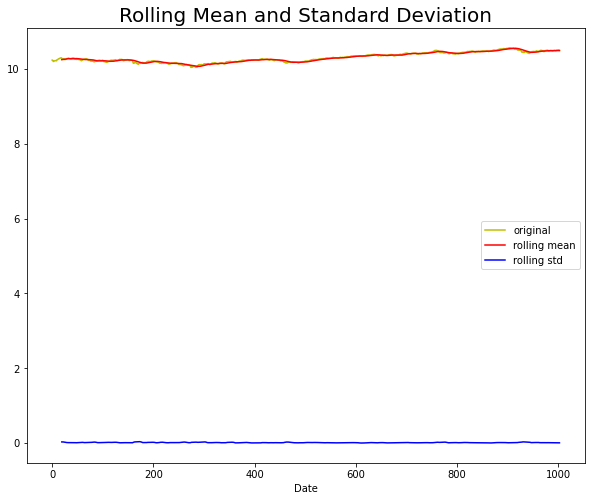

Results of dickey fuller test
ADF Test Statistic : -0.5063496559707529
p-value : 0.8907714361384154
#Lags Used : 6
Number of Observations Used : 993
Weak evidence against null hypothesis, time series is non-stationary 


In [76]:
train_log.dropna(inplace = True)
test_log.dropna(inplace = True)

test_stationarity(train_log)

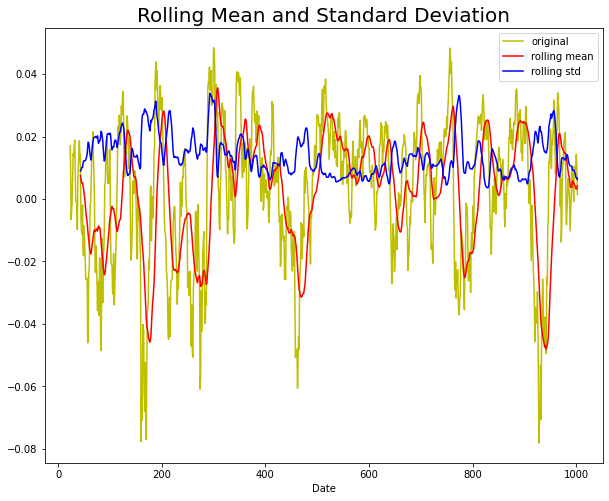

Results of dickey fuller test
ADF Test Statistic : -6.541831419968806
p-value : 9.305308769625531e-09
#Lags Used : 3
Number of Observations Used : 973
Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


In [77]:
train_log_diff = train_log - mav
train_log_diff.dropna(inplace = True)

test_stationarity(train_log_diff)

In [78]:
#Using auto arima to make predictions using log data
from pmdarima import auto_arima
model = auto_arima(train_log, trace = True, error_action = 'ignore', suppress_warnings = True)
model.fit(train_log)
predictions = model.predict(n_periods = len(test))
predictions = pd.DataFrame(predictions,index = test_log.index,columns=['Prediction'])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-6695.839, Time=1.67 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-6700.141, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-6701.586, Time=0.24 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-6701.681, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-6701.204, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-6700.257, Time=0.81 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-6699.799, Time=0.97 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-6697.783, Time=0.62 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-6702.851, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-6701.366, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-6700.941, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-6702.758, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-6698.902, Time=0.28 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 5.692 seconds


Text(0, 0.5, 'Actual Stock Price')

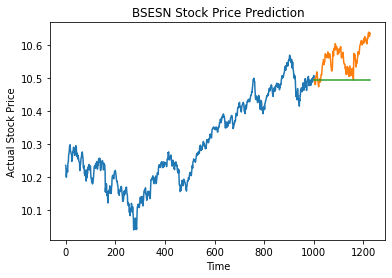

In [79]:
plt.plot(train_log, label='Train')
plt.plot(test_log, label='Test')
plt.plot(predictions, label='Prediction')
plt.title('BSESN Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')

In [80]:
#Calculating error
rms = np.sqrt(mean_squared_error(test_log,predictions))
print("RMSE : ", rms)

RMSE :  0.0759730171376019


TEXTUAL ANALYSIS

In [44]:
cols = ['Date','Category','News']
df_news = pd.read_csv('india-news-headlines.csv', names = cols)
df_news

,Date,Category,News
0,publish_date,headline_category,headline_text
1,20150101,life-style.food.recipes,Breakfast recipe for diabetics: Moong idlis
2,20150101,life-style.food.recipes,Recipe: Delicious coconut balls
3,20150101,life-style.beauty,Cure that dandruff naturally
4,20150101,life-style.food.recipes,Recipe: Kerala Chicken curry
...,...,...,...
1201916,20191231,gadgets-news,vivo s1 pro with 48mp quad camera setup launch...
1201917,20191231,world.pakistan,muslims mob attack gurdwara nankana sahib with...
1201918,20191231,world.us,general soleimani should have been eliminated ...
1201919,20191231,india,india strongly condemns vandalism at nankana s...


In [45]:
df_news.drop(0, inplace=True)
df_news.drop('Category', axis = 1, inplace=True)
df_news.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1201920 entries, 1 to 1201920
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   Date    1201920 non-null  object
 1   News    1201920 non-null  object
dtypes: object(2)
memory usage: 27.5+ MB


In [46]:
 #Converting data type of Date column 
 df_news['Date'] = pd.to_datetime(df_news['Date'],format= '%Y%m%d')
 df_news

,Date,News
1,2015-01-01,Breakfast recipe for diabetics: Moong idlis
2,2015-01-01,Recipe: Delicious coconut balls
3,2015-01-01,Cure that dandruff naturally
4,2015-01-01,Recipe: Kerala Chicken curry
5,2015-01-01,Recipe: Mocha Coffee
...,...,...
1201916,2019-12-31,vivo s1 pro with 48mp quad camera setup launch...
1201917,2019-12-31,muslims mob attack gurdwara nankana sahib with...
1201918,2019-12-31,general soleimani should have been eliminated ...
1201919,2019-12-31,india strongly condemns vandalism at nankana s...


In [47]:
#Grouping the headlines for each day
df_news['News'] = df_news.groupby(['Date']).transform(lambda x : ' '.join(x)) 
df_news = df_news.drop_duplicates() 
df_news.reset_index(inplace = True, drop = True)
df_news

,Date,News
0,2015-01-01,Breakfast recipe for diabetics: Moong idlis Re...
1,2015-01-02,Drink smart with these party tips How to say s...
2,2015-01-03,3 Stylish New Year cocktail recipes you'll LOV...
3,2015-01-04,How to get that bikini body Rules of love-maki...
4,2015-01-05,Recipe: Strawberry cupcakes Recipe: Kaju jeera...
...,...,...
1821,2019-12-27,All schools in Naintial to be closed for two d...
1822,2019-12-28,Shivin Narang on Bigg Boss 13 contestants: It'...
1823,2019-12-29,The year of flexi habits The year of self Less...
1824,2019-12-30,Kareena Kapoor is holidaying in Switzerland an...


In [48]:
df_news['News']

0       Breakfast recipe for diabetics: Moong idlis Re...
1       Drink smart with these party tips How to say s...
2       3 Stylish New Year cocktail recipes you'll LOV...
3       How to get that bikini body Rules of love-maki...
4       Recipe: Strawberry cupcakes Recipe: Kaju jeera...
                              ...                        
1821    All schools in Naintial to be closed for two d...
1822    Shivin Narang on Bigg Boss 13 contestants: It'...
1823    The year of flexi habits The year of self Less...
1824    Kareena Kapoor is holidaying in Switzerland an...
1825    herbal weight loss supplements to help you get...
Name: News, Length: 1826, dtype: object

In [49]:
#Cleaning headlines
c = []
for i in range(0,len(df_news['News'])):
    news = re.sub('[^a-zA-Z]',' ',df_news['News'][i])
    news = news.lower()
    news = news.split()
    news = [ps.stem(word) for word in news if not word in set(stopwords.words('english'))]
    news=' '.join(news)
    c.append(news)

In [50]:
df_news['News'] = pd.Series(c)
df_news

,Date,News
0,2015-01-01,breakfast recip diabet moong idli recip delici...
1,2015-01-02,drink smart parti tip say sorri kid take child...
2,2015-01-03,stylish new year cocktail recip love dessert r...
3,2015-01-04,get bikini bodi rule love make appli work bake...
4,2015-01-05,recip strawberri cupcak recip kaju jeera rice ...
...,...,...
1821,2019-12-27,school naintial close two day nirbhay wadhwa u...
1822,2019-12-28,shivin narang bigg boss contest crazi peopl be...
1823,2019-12-29,year flexi habit year self lesson learnt confu...
1824,2019-12-30,kareena kapoor holiday switzerland internet st...


In [51]:
#Functions to get the subjectivity and polarity
def getSubjectivity(text):
  return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
  return  TextBlob(text).sentiment.polarity

In [52]:
#Adding subjectivity and polarity columns
df_news['Subjectivity'] = df_news['News'].apply(getSubjectivity)
df_news['Polarity'] = df_news['News'].apply(getPolarity)
df_news

,Date,News,Subjectivity,Polarity
0,2015-01-01,breakfast recip diabet moong idli recip delici...,0.432083,0.083989
1,2015-01-02,drink smart parti tip say sorri kid take child...,0.427002,0.059439
2,2015-01-03,stylish new year cocktail recip love dessert r...,0.412459,0.072817
3,2015-01-04,get bikini bodi rule love make appli work bake...,0.407143,0.089526
4,2015-01-05,recip strawberri cupcak recip kaju jeera rice ...,0.409543,0.119753
...,...,...,...,...
1821,2019-12-27,school naintial close two day nirbhay wadhwa u...,0.357721,0.058962
1822,2019-12-28,shivin narang bigg boss contest crazi peopl be...,0.375351,0.062086
1823,2019-12-29,year flexi habit year self lesson learnt confu...,0.425854,0.050875
1824,2019-12-30,kareena kapoor holiday switzerland internet st...,0.384306,0.060182


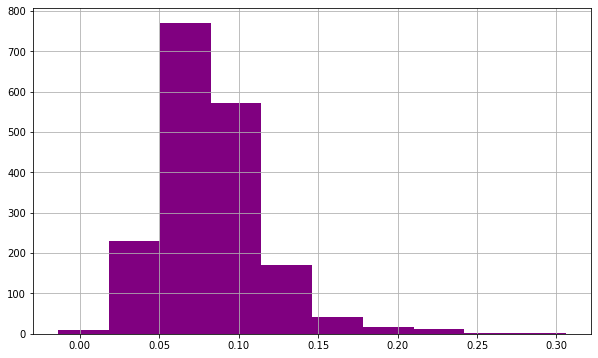

In [53]:
plt.figure(figsize = (10,6))
df_news['Polarity'].hist(color = 'purple')

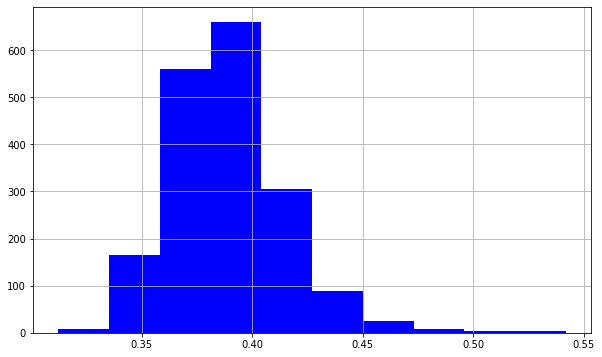

In [54]:
plt.figure(figsize = (10,6))
df_news['Subjectivity'].hist(color = 'blue')

In [55]:
#Adding sentiment score to df_news
sia = SentimentIntensityAnalyzer()

df_news['Compound'] = [sia.polarity_scores(v)['compound'] for v in df_news['News']]
df_news['Negative'] = [sia.polarity_scores(v)['neg'] for v in df_news['News']]
df_news['Neutral'] = [sia.polarity_scores(v)['neu'] for v in df_news['News']]
df_news['Positive'] = [sia.polarity_scores(v)['pos'] for v in df_news['News']]
df_news

,Date,News,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,2015-01-01,breakfast recip diabet moong idli recip delici...,0.432083,0.083989,-0.9991,0.118,0.792,0.091
1,2015-01-02,drink smart parti tip say sorri kid take child...,0.427002,0.059439,-0.9991,0.128,0.768,0.103
2,2015-01-03,stylish new year cocktail recip love dessert r...,0.412459,0.072817,-0.9996,0.127,0.787,0.086
3,2015-01-04,get bikini bodi rule love make appli work bake...,0.407143,0.089526,-0.9998,0.131,0.796,0.073
4,2015-01-05,recip strawberri cupcak recip kaju jeera rice ...,0.409543,0.119753,-0.9989,0.122,0.781,0.097
...,...,...,...,...,...,...,...,...
1821,2019-12-27,school naintial close two day nirbhay wadhwa u...,0.357721,0.058962,-0.9999,0.179,0.756,0.065
1822,2019-12-28,shivin narang bigg boss contest crazi peopl be...,0.375351,0.062086,-0.9999,0.170,0.769,0.061
1823,2019-12-29,year flexi habit year self lesson learnt confu...,0.425854,0.050875,-0.9999,0.163,0.758,0.079
1824,2019-12-30,kareena kapoor holiday switzerland internet st...,0.384306,0.060182,-0.9999,0.167,0.757,0.076


In [56]:
df_merge = pd.merge(df_prices, df_news, how='inner', on='Date')
df_merge

,Date,Open,High,Low,Close,Adj Close,Volume,News,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,2015-01-02,27521.279297,27937.470703,27519.259766,27887.900391,27887.900391,7400.0,drink smart parti tip say sorri kid take child...,0.427002,0.059439,-0.9991,0.128,0.768,0.103
1,2015-01-05,27978.429688,28064.490234,27786.849609,27842.320313,27842.320313,9200.0,recip strawberri cupcak recip kaju jeera rice ...,0.409543,0.119753,-0.9989,0.122,0.781,0.097
2,2015-01-06,27694.230469,27698.929688,26937.060547,26987.460938,26987.460938,14100.0,turn garden happi teeth jewelleri latest trend...,0.386223,0.046943,-0.9998,0.133,0.790,0.077
3,2015-01-07,26983.429688,27051.599609,26776.119141,26908.820313,26908.820313,12200.0,ex lover friend water diet bad tip stay happi ...,0.386953,0.032975,-0.9999,0.154,0.765,0.081
4,2015-01-08,27178.769531,27316.410156,27101.939453,27274.710938,27274.710938,8200.0,home manicur recip spice beetroot disinfect wa...,0.387770,0.076619,-0.9998,0.131,0.788,0.080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1219,2019-12-23,41548.261719,41701.621094,41474.609375,41642.660156,41642.660156,6200.0,weekli horoscop decemb check predict zodiac si...,0.412031,0.057669,-0.9995,0.143,0.765,0.092
1220,2019-12-24,41684.511719,41702.980469,41423.070313,41461.261719,41461.261719,4400.0,choker necklac make sassi throwback style rash...,0.401002,0.064272,-0.9998,0.144,0.773,0.082
1221,2019-12-26,41543.800781,41543.800781,41132.890625,41163.761719,41163.761719,5600.0,nit develop cold storag system store fruit veg...,0.372711,0.039655,-0.9999,0.152,0.779,0.069
1222,2019-12-27,41297.078125,41611.269531,41264.921875,41575.140625,41575.140625,6100.0,school naintial close two day nirbhay wadhwa u...,0.357721,0.058962,-0.9999,0.179,0.756,0.065


In [57]:
df = df_merge[['Close','Subjectivity', 'Polarity', 'Compound', 'Negative', 'Neutral' ,'Positive']]
df

,Close,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,27887.900391,0.427002,0.059439,-0.9991,0.128,0.768,0.103
1,27842.320313,0.409543,0.119753,-0.9989,0.122,0.781,0.097
2,26987.460938,0.386223,0.046943,-0.9998,0.133,0.790,0.077
3,26908.820313,0.386953,0.032975,-0.9999,0.154,0.765,0.081
4,27274.710938,0.387770,0.076619,-0.9998,0.131,0.788,0.080
...,...,...,...,...,...,...,...
1219,41642.660156,0.412031,0.057669,-0.9995,0.143,0.765,0.092
1220,41461.261719,0.401002,0.064272,-0.9998,0.144,0.773,0.082
1221,41163.761719,0.372711,0.039655,-0.9999,0.152,0.779,0.069
1222,41575.140625,0.357721,0.058962,-0.9999,0.179,0.756,0.065


In [58]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
new_df = pd.DataFrame(sc.fit_transform(df))
new_df.columns = df.columns
new_df.index = df.index
new_df.head()

,Close,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,0.263542,0.467934,0.228278,0.00045,0.361702,0.444444,0.478261
1,0.261109,0.387016,0.417200,0.00055,0.297872,0.588889,0.413043
2,0.215467,0.278933,0.189137,0.00010,0.414894,0.688889,0.195652
3,0.211268,0.282318,0.145385,0.00005,0.638298,0.411111,0.239130
4,0.230803,0.286106,0.282091,0.00010,0.393617,0.666667,0.228261


In [59]:
X = new_df.drop('Close', axis=1)
y =new_df['Close']

In [60]:
X.head()

,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,0.467934,0.228278,0.00045,0.361702,0.444444,0.478261
1,0.387016,0.417200,0.00055,0.297872,0.588889,0.413043
2,0.278933,0.189137,0.00010,0.414894,0.688889,0.195652
3,0.282318,0.145385,0.00005,0.638298,0.411111,0.239130
4,0.286106,0.282091,0.00010,0.393617,0.666667,0.228261


In [61]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)
x_train.shape

(979, 6)

In [62]:
x_train[:10]

,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
359,0.220204,0.281086,0.00010,0.553191,0.300000,0.434783
743,0.358505,0.271120,0.00010,0.574468,0.333333,0.380435
681,0.259733,0.160630,0.00005,0.617021,0.422222,0.250000
901,0.307586,0.402011,0.00040,0.255319,0.622222,0.423913
548,0.183069,0.188262,0.00010,0.382979,0.722222,0.195652
904,0.015381,0.263394,0.00005,0.542553,0.511111,0.239130
1039,0.541122,0.543801,0.00025,0.414894,0.522222,0.358696
467,0.205376,0.357111,0.00005,0.638298,0.422222,0.228261
85,0.324463,0.347983,0.00015,0.510638,0.422222,0.358696
192,0.435857,0.479194,0.00065,0.340426,0.411111,0.543478


In [63]:
rf = RandomForestRegressor()
rf.fit(x_train, y_train)
prediction=rf.predict(x_test)

In [64]:
print(prediction[:10])
print(y_test[:10])
print(mean_squared_error(prediction,y_test))

[0.56900133 0.65381814 0.40213346 0.41479438 0.5887583  0.52221731
 0.57886431 0.73085042 0.59790365 0.58271874]
853     0.658574
5       0.240610
912     0.788380
124     0.280673
998     0.720396
941     0.593473
1074    0.875659
989     0.708024
52      0.283467
529     0.309214
Name: Close, dtype: float64
0.044734065297256


In [65]:
adb = AdaBoostRegressor()
adb.fit(x_train, y_train)
predictions = adb.predict(x_test)

In [66]:
print(mean_squared_error(predictions, y_test))

0.049009608942640545


In [67]:
from sklearn.tree import DecisionTreeRegressor
dec_tree = DecisionTreeRegressor()
dec_tree.fit(x_train, y_train)
predictions = dec_tree.predict(x_test)

In [68]:
print(predictions[:10])
print(y_test[:10])
print(mean_squared_error(predictions,y_test))

[0.79743516 0.92551627 0.52952711 0.22954278 0.72776935 0.64877199
 0.69289974 0.80251691 0.05927529 0.72557448]
853     0.658574
5       0.240610
912     0.788380
124     0.280673
998     0.720396
941     0.593473
1074    0.875659
989     0.708024
52      0.283467
529     0.309214
Name: Close, dtype: float64
0.09108309698560868


In [69]:
lgb = lightgbm.LGBMRegressor()
lgb.fit(x_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [70]:
predictions = lgb.predict(x_test)
print(mean_squared_error(predictions,y_test))

0.050222162630987485


In [71]:
xgb = xgboost.XGBRegressor()
xgb.fit(x_train, y_train)

[10:50:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [72]:
predictions = xgb.predict(x_test)
print(mean_squared_error(predictions,y_test))

0.043341490145982466


We observe that Xgboost model performs the best for the sentiment analysis